# Explanation of this notebook

This notebook got three purposes:
1. Improve the estimated delivery date given to customers at the purchase moment
2. Predict wether a delivery is gonna be late
3. Use clustering (k-means) to sugest where and how many warehouses to construct

# <font color='blue'>Setup 1</font>: Load Libraries

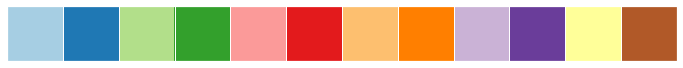

In [67]:
import numpy as np
import pandas as pd
import sys, os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
sns.set()
sns.palplot(sns.color_palette("Paired"))
plt.rcParams['figure.figsize'] = (15.0, 8.0)
plt.style.use('ggplot')

# <font color='blue'>Setup 2</font>: Load data

In [27]:
def load_table(tablename):
    """ Defining the current directory and path to where data are located. Joining path to
    data folder and table name in order to read the table into a Pandas DataFrame"""
    
    file_path = os.path.join ('../data/') 

    df = os.path.join(file_path, tablename) 
    df = pd.read_csv(df, sep=',', encoding="latin1") 
    
    return df

In [28]:
# Reading the olist_orders table
orders = load_table('olist_orders_dataset.csv')
order_items = load_table('olist_order_items_dataset.csv')
customers = load_table('olist_customers_dataset.csv')
customers.columns = ['customer_id','customer_unique_id','geolocation_zip_code_prefix',
                     'customer_city','customer_state']
sellers = load_table('olist_sellers_dataset.csv')
sellers.columns = ['seller_id','geolocation_zip_code_prefix',
                     'seller_city','seller_state']
geo = load_table('olist_geolocation_dataset.csv')

In [29]:
order_items

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14
...,...,...,...,...,...,...,...
112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41
112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53
112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95
112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72


In [30]:
order_items[order_items['order_id']=='8272b63d03f5f79c56e9e4120aec44ef']

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
57297,8272b63d03f5f79c56e9e4120aec44ef,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57298,8272b63d03f5f79c56e9e4120aec44ef,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57299,8272b63d03f5f79c56e9e4120aec44ef,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57300,8272b63d03f5f79c56e9e4120aec44ef,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57301,8272b63d03f5f79c56e9e4120aec44ef,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57302,8272b63d03f5f79c56e9e4120aec44ef,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57303,8272b63d03f5f79c56e9e4120aec44ef,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57304,8272b63d03f5f79c56e9e4120aec44ef,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57305,8272b63d03f5f79c56e9e4120aec44ef,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
57306,8272b63d03f5f79c56e9e4120aec44ef,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


In [31]:
order_items.describe(include='O')

,order_id,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650
unique,98666,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2018-03-01 02:50:48
freq,21,527,2033,21


In [32]:
order_items_filt = order_items.groupby(['order_id', 'product_id','seller_id','shipping_limit_date','freight_value','price'])['order_item_id'].agg({"quantity":"max"}).reset_index()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)

  """Entry point for launching an IPython kernel.


In [33]:
order_items_filt['order_price'] = order_items_filt['price']*order_items_filt['quantity']

In [34]:
order_items_filt[order_items_filt['quantity']>1]

,order_id,product_id,seller_id,shipping_limit_date,freight_value,price,quantity,order_price
13,0008288aa423d2a3f00fcb17cd7d8719,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,13.37,49.90,2,99.80
31,00143d0f86d6fbd9f9b38ab440ac16f5,e95ee6822b66ac6058e2e4aff656071a,a17f621c590ea0fab3d5d883e1630ec6,2017-10-20 16:07:52,15.10,21.33,3,63.99
39,001ab0a7578dd66cd4b0a71f5b6e1e41,0b0172eb0fd18479d29c3bc122c058c2,5656537e588803a555b8eb41f07a944b,2018-01-04 02:33:42,17.63,24.89,3,74.67
43,001d8f0e34a38c37f7dba2a37d4eba8b,e67307ff0f15ade43fcb6e670be7a74c,f4aba7c0bca51484c30ab7bdc34bcdd1,2017-05-18 17:35:11,7.78,18.99,2,37.98
69,002c9def9c9b951b1bec6d50753c9891,2d9ff06c8870a518f5f6909774e140fb,00720abe85ba0859807595bbf045a33b,2018-05-21 17:32:03,8.90,78.00,2,156.00
...,...,...,...,...,...,...,...,...
102362,ffd84ab39cd5e873d8dba24342e65c01,fcf50ee5ad1f1a48671052487d2b0bff,0be8ff43f22e456b4e0371b2245e4d01,2017-10-11 19:49:17,7.78,24.90,2,49.80
102385,ffe4b41e99d39f0b837a239110260530,e97df839917a6e93404867b1d0319bfc,42bde9fef835393bb8a8849cb6b7f245,2017-09-07 21:25:40,15.79,19.00,2,38.00
102396,ffecd5a79a0084f6a592288c67e3c298,50fd2b788dc166edd20512370dac54df,8b321bb669392f5163d04c59e235e066,2018-03-05 20:15:27,15.79,21.90,3,65.70
102413,fff8287bbae429a99bb7e8c21d151c41,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,48.14,180.00,2,360.00


In [35]:
order_items_filt.describe()

,freight_value,price,quantity,order_price
count,102425.000000,102425.000000,102425.000000,102425.000000
mean,20.111152,124.422006,1.150539,136.778317
std,15.884700,188.926084,0.563005,209.629971
min,0.000000,0.850000,1.000000,0.850000
25%,13.140000,40.000000,1.000000,45.900000
50%,16.320000,78.800000,1.000000,85.000000
75%,21.220000,139.000000,1.000000,149.900000
max,409.680000,6735.000000,21.000000,13440.000000


In [36]:
order_items_filt = order_items_filt.groupby(['order_id','seller_id','shipping_limit_date','freight_value','quantity'])['order_price'].agg('sum').reset_index()

In [37]:
order_items_filt

,order_id,seller_id,shipping_limit_date,freight_value,quantity,order_price
0,00010242fe8c5a6d1ba2dd792cb16214,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,13.29,1,58.90
1,00018f77f2f0320c557190d7a144bdd3,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,19.93,1,239.90
2,000229ec398224ef6ca0657da4fc703e,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,17.87,1,199.00
3,00024acbcdf0a6daa1e931b038114c75,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.79,1,12.99
4,00042b26cf59d7ce69dfabb4e55b4fd9,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,18.14,1,199.90
...,...,...,...,...,...,...
102420,fffc94f6ce00a00581880bf54a75a037,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,43.41,1,299.99
102421,fffcd46ef2263f404302a634eb57f7eb,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,36.53,1,350.00
102422,fffce4705a9662cd70adb13d4a31832d,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,16.95,1,99.90
102423,fffe18544ffabc95dfada21779c9644f,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,8.72,1,55.99


In [38]:
order_items_filt.describe()

,freight_value,quantity,order_price
count,102425.000000,102425.000000,102425.000000
mean,20.111152,1.150539,136.778317
std,15.884700,0.563005,209.629971
min,0.000000,1.000000,0.850000
25%,13.140000,1.000000,45.900000
50%,16.320000,1.000000,85.000000
75%,21.220000,1.000000,149.900000
max,409.680000,21.000000,13440.000000


# <font color='blue'>Setup 3</font>: Merge datasets

In [39]:
# Merging geo location to sellers and customers dataset
customers_geo = customers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
customers_geo = customers_geo[['customer_id', 'geolocation_lat','geolocation_lng']]
customers_geo.columns = ['customer_id', 'customer_lat','customer_lon']
customers_geo = customers_geo.groupby('customer_id')['customer_lat','customer_lon'].agg('mean').reset_index()

sellers_geo = sellers.merge(geo, on = "geolocation_zip_code_prefix", how = "left")
sellers_geo = sellers_geo[['seller_id', 'geolocation_lat','geolocation_lng']]
sellers_geo.columns = ['seller_id', 'seller_lat','seller_lon']
sellers_geo = sellers_geo.groupby('seller_id')['seller_lat','seller_lon'].agg('mean').reset_index()

In [40]:
# Merging geo location to orders dataset
order_items_all = order_items_filt.merge(sellers_geo, on='seller_id', how='left')

orders_all = orders.merge(customers_geo, on='customer_id', how='left')
orders_all = orders_all.merge(order_items_all, on='order_id',how='left')

orders_all = orders_all[['order_id','order_status', 'customer_id', 'seller_id', 
                         'order_purchase_timestamp','order_approved_at',
                         'order_delivered_carrier_date','shipping_limit_date',
                         'order_delivered_customer_date','order_estimated_delivery_date',
                         'order_price','customer_lat','customer_lon','seller_lat', 'seller_lon']]

In [41]:
orders_all.head()

,order_id,order_status,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,delivered,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,delivered,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,delivered,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,delivered,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,delivered,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,-23.676370,-46.514627,-23.543395,-46.262086


In [42]:
# Filter all orders that has been delivered
delivered_orders = orders_all[orders_all['order_status']=='delivered']
delivered_orders = delivered_orders.drop('order_status', axis=1)

In [43]:
delivered_orders

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,customer_lat,customer_lon,seller_lat,seller_lon
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-06 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,29.99,-23.576983,-46.587161,-23.680729,-46.444238
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,289cdb325fb7e7f891c38608bf9e0962,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-07-30 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,118.70,-12.177924,-44.660711,-19.807681,-43.980427
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-13 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,159.90,-16.745150,-48.514783,-21.363502,-48.229601
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,66922902710d126a0e7d26b0e3805106,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-11-23 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,45.00,-5.774190,-35.271143,-19.837682,-43.924053
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2c9e548be18521d1c43cde1c582c6de8,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-19 20:31:37,2018-02-16 18:17:02,2018-02-26 00:00:00,19.90,-23.676370,-46.514627,-23.543395,-46.262086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103195,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,e24fc9fcd865784fb25705606fe3dfe7,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-15 09:54:05,2017-03-17 15:08:01,2017-03-28 00:00:00,72.00,-23.178000,-45.883818,-22.961694,-46.523854
103196,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,1f9ab4708f3056ede07124aad39a2554,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-12 13:10:37,2018-02-28 17:37:56,2018-03-02 00:00:00,174.90,-24.001500,-46.449864,-21.930548,-50.498348
103197,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,d50d79cb34e38265a8649c383dcffd48,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-05 15:04:16,2017-09-21 11:24:17,2017-09-27 00:00:00,205.99,-17.898358,-39.373630,-23.553642,-46.452661
103198,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,a1043bafd471dff536d0c462352beb48,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-12 21:36:21,2018-01-25 23:32:54,2018-02-15 00:00:00,359.98,-22.562825,-42.694574,-20.940578,-45.827237


In [44]:
#Changing these columns to datetimes
delivered_orders.order_purchase_timestamp = pd.to_datetime(delivered_orders.order_purchase_timestamp)
delivered_orders.order_approved_at = pd.to_datetime(delivered_orders.order_approved_at)
delivered_orders.shipping_limit_date = pd.to_datetime(delivered_orders.shipping_limit_date)
delivered_orders.order_delivered_carrier_date = pd.to_datetime(delivered_orders.order_delivered_carrier_date)
delivered_orders.order_estimated_delivery_date = pd.to_datetime(delivered_orders.order_estimated_delivery_date)
delivered_orders.order_delivered_customer_date = pd.to_datetime(delivered_orders.order_delivered_customer_date)

In [45]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders.shipping_limit_date - delivered_orders.order_delivered_carrier_date
delivered_orders['shipping_difference'] = delivered_orders['shipping_difference'].dt.days

# KOMMENTER NEDENSTÅENDE

In [56]:
delivered_orders = delivered_orders.drop(89664)

In [57]:
delivered_orders['shipping_difference'].describe()

count    100193.000000
mean          2.832383
std           3.743680
min        -117.000000
25%           1.000000
50%           3.000000
75%           5.000000
max         175.000000
Name: shipping_difference, dtype: float64

In [58]:
delivered_orders[delivered_orders['shipping_difference']<0]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,customer_lat,customer_lon,seller_lat,seller_lon,shipping_difference,delivery_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,-23.572939,-46.651115,-23.676570,-46.669897,-12.0,-12.0
29,91b2a010e1e45e6ba3d133fa997597be,cce89a605105b148387c52e286ac8335,7d13fca15225358621be4086e1eb0964,2018-05-02 11:45:38,2018-05-03 12:55:01,2018-05-10 16:16:00,2018-05-09 12:55:01,2018-05-16 20:56:24,2018-05-23,178.99,-23.697396,-46.530322,-21.172861,-47.823700,-2.0,6.0
31,f70a0aff17df5a6cdd9a7196128bd354,456dc10730fbdba34615447ea195d643,5dceca129747e92ff8ef7a997dc4f8ca,2017-08-10 11:58:33,2017-08-12 02:45:24,2017-08-17 15:35:07,2017-08-17 02:45:24,2017-08-18 14:28:02,2017-08-23,279.00,-23.606375,-46.737491,-22.757883,-47.417055,-1.0,4.0
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,-21.874288,-51.844970,-27.231416,-49.657477,-14.0,-8.0
59,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,391fc6631aebcf3004804e51b40bcf1e,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-03-22 14:03:09,2017-03-17 18:14:36,2017-04-06 13:37:16,2017-03-30,84.90,-22.863075,-47.149981,-21.757321,-48.829744,-5.0,-8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103093,5dea57306e01caa42ad0b07b85042953,0b3a3c105d2d5b981fcf34c111fb18a4,2eb70248d66e0e3ef83659f71b244378,2018-07-16 01:31:13,2018-07-16 01:47:22,2018-07-26 11:05:00,2018-07-26 01:47:22,2018-08-02 19:42:02,2018-08-14,155.97,-27.399055,-51.225565,-22.914020,-47.013535,-1.0,11.0
103149,e8455c3c0bc5471436a335a0de392761,3a4562b466aea32a6aa09fe85e67d400,4d6d651bd7684af3fffabd5f08d12e5a,2018-02-13 10:42:15,2018-02-15 03:47:45,2018-02-21 20:33:20,2018-02-21 02:47:45,2018-03-02 00:28:57,2018-03-09,119.80,-25.386124,-49.264055,-22.275249,-48.543584,-1.0,6.0
103154,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,5b0cc932433fa5184b5b94bfe6bcc256,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-08 23:04:06,2018-08-21 00:03:26,2018-08-16,190.00,-23.662299,-46.421695,-21.757321,-48.829744,-7.0,-6.0
103172,e8fd20068b9f7e6ec07068bb7537f781,609b9fb8cad4fe0c7b376f77c8ab76ad,218d46b86c1881d022bce9c68a7d4b15,2017-08-10 21:21:07,2017-08-10 21:35:26,2017-08-18 16:42:51,2017-08-17 21:35:26,2017-08-23 15:36:29,2017-08-31,712.00,-23.544377,-46.565376,-21.112713,-47.790810,-1.0,7.0


In [59]:
#Calculating difference between shipping_limit_date and order_delivered_carrier_date
delivered_orders['delivery_difference'] = delivered_orders.order_estimated_delivery_date - delivered_orders.order_delivered_customer_date
delivered_orders['delivery_difference'] = delivered_orders['delivery_difference'].dt.days

In [60]:
delivered_orders['delivery_difference'].describe()

count    100187.000000
mean         10.981165
std          10.202044
min        -189.000000
25%           6.000000
50%          12.000000
75%          16.000000
max         146.000000
Name: delivery_difference, dtype: float64

In [61]:
delivered_orders[delivered_orders['delivery_difference']<0]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,customer_lat,customer_lon,seller_lat,seller_lon,shipping_difference,delivery_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,-23.572939,-46.651115,-23.676570,-46.669897,-12.0,-12.0
25,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,c0563dd588b775f2e37747ef6ad6c92c,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-02-26 22:25:22,2018-02-28 02:30:44,2018-03-21 22:03:54,2018-03-12,109.90,-22.879477,-43.440264,-23.622288,-46.536901,1.0,-10.0
36,8563039e855156e48fccee4d611a3196,5f16605299d698660e0606f7eae2d2f9,955fee9216a65b617aa5c0531780ce60,2018-02-17 15:59:46,2018-02-17 16:15:34,2018-02-20 23:03:56,2018-02-22 15:15:34,2018-03-20 00:59:25,2018-03-20,78.00,-12.478669,-49.122905,-23.691013,-46.703810,1.0,-1.0
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,-21.874288,-51.844970,-27.231416,-49.657477,-14.0,-8.0
58,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,db4350fd57ae30082dec7acbaacc17f9,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-03-15 00:31:19,2018-03-15 15:30:45,2018-04-03 13:28:46,2018-04-02,45.98,-10.971622,-37.067341,-23.580395,-46.591326,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103154,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,5b0cc932433fa5184b5b94bfe6bcc256,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-15 17:42:00,2018-08-08 23:04:06,2018-08-21 00:03:26,2018-08-16,190.00,-23.662299,-46.421695,-21.757321,-48.829744,-7.0,-6.0
103155,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,620c87c171fb2a6dd6e8bb4dec959fc6,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-03-14 19:27:23,2018-03-19 22:30:45,2018-04-05 19:59:49,2018-04-02,249.90,-23.568188,-46.594754,-22.540797,-43.201235,5.0,-4.0
103181,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,fa40cc5b934574b62717c68f3d678b6d,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-10-17 17:04:42,2017-10-19 04:28:24,2017-11-21 17:06:59,2017-10-31,36.90,-21.772226,-48.180222,-23.472815,-46.600729,1.0,-22.0
103183,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,701938c450705b8ae65fc923b70f35c7,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-03-22 21:11:58,2018-03-27 20:05:26,2018-04-11 00:48:31,2018-04-09,109.97,-22.951602,-47.001996,-20.818959,-49.377346,4.0,-3.0


In [133]:
delivered_orders[((delivered_orders['delivery_difference']==delivered_orders['shipping_difference']) & (delivered_orders['shipping_difference']<0))| ((delivered_orders['delivery_difference']>delivered_orders['shipping_difference'])& (delivered_orders['delivery_difference']<0))]

,order_id,customer_id,seller_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,shipping_limit_date,order_delivered_customer_date,order_estimated_delivery_date,order_price,customer_lat,customer_lon,seller_lat,seller_lon,shipping_difference,delivery_difference
20,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,633ecdf879b94b5337cca303328e4a25,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-06 17:50:03,2017-09-25 04:04:09,2017-10-09 22:23:46,2017-09-28,109.90,-23.572939,-46.651115,-23.676570,-46.669897,-12.0,-12.0
42,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-11-30 00:21:09,2017-12-28 18:59:23,2017-12-21,339.00,-21.874288,-51.844970,-27.231416,-49.657477,-14.0,-8.0
334,16c24987724018f73b746aacfbb5f8e8,ffdc2af7160aed3bad21cbc8ec68c0c5,973f21788dfab357250f69a8dcb7ddee,2017-05-20 02:48:00,2017-05-23 03:50:25,2017-06-05 13:58:19,2017-05-29 03:50:25,2017-06-16 16:52:02,2017-06-09,135.00,-19.931856,-43.932647,-20.437205,-44.762034,-8.0,-8.0
416,884b1394fc8888e6a877df86eb19e74c,7ee968b8ed74301e0cbd3e44416cad9d,f84fa566034f5e8e880a07ec624c56af,2018-03-19 21:50:14,2018-03-19 22:08:28,2018-03-27 14:04:29,2018-03-25 22:08:28,2018-03-29 17:32:05,2018-03-29,47.65,-23.548806,-46.830240,-23.086339,-47.216887,-2.0,-1.0
789,4190ab61a7fced69f3ee84d1da1120cc,3df7ff0b86935d5249e4d6cd56b89131,4b5f66b7adcf57f1ecc0d3c07dd6b177,2017-12-08 11:38:00,2017-12-09 02:36:21,2018-01-12 00:35:33,2017-12-14 02:36:21,2018-01-31 19:08:40,2018-01-11,172.50,-16.581827,-39.136345,-23.382472,-51.927966,-29.0,-21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102471,79e449c1c0d89c880cb601cd5856976c,8636a960c2d0bae14b65c2ba881f0916,bd15ee794d5e640d9dd71b665b2ab15b,2018-03-30 19:43:03,2018-03-30 20:27:22,2018-04-17 17:28:37,2018-04-06 20:27:22,2018-05-11 19:18:47,2018-05-02,32.90,-4.938638,-37.973826,-21.140496,-47.766518,-11.0,-10.0
102751,338b0cffa439f5e95d42cd30d7ace847,0176d6c1606400bd49c88871e15839bb,b37c4c02bda3161a7546a4e6d222d5b2,2017-04-23 12:07:48,2017-04-25 08:05:21,2017-05-04 09:10:15,2017-05-03 08:05:21,2017-05-16 14:33:34,2017-05-16,175.00,-22.830656,-43.042041,-23.531307,-46.494795,-2.0,-1.0
102837,31a7dd4d08e48968ab49478c64c7075a,f2ad8c1d461bb9d11944d8ab973f3836,c990d6cf976a5718aaedc539f383ab88,2018-01-14 17:18:45,2018-01-16 03:39:56,2018-02-09 16:38:01,2018-01-22 03:39:56,2018-02-14 16:07:43,2018-01-30,31.80,-23.689283,-46.619715,-22.735332,-47.176654,-19.0,-16.0
103040,141c7645c99eed7a80fa7ec9d6c40ad0,30367cbd4765dc3372734e4a100cbb50,87142160b41353c4e5fca2360caf6f92,2018-01-15 15:57:07,2018-01-15 16:12:36,2018-01-26 21:15:16,2018-01-19 16:12:36,2018-02-08 15:46:34,2018-02-06,34.90,-23.004991,-43.547845,-30.008182,-51.201304,-8.0,-3.0


# <font color='blue'>Part 1</font>: Descriptive analysis

When a purchase is approved, the seller is given a `shipping_limit_date` telling when they have to pass on the product to a third party logistic company. While the customer is given a `estimated_delivery_date`.

In [142]:
(1-96477/100195)*100

3.7107640101801453

In [138]:
delivered_orders.describe(include='O')

,order_id,customer_id,seller_id
count,100195,100195,100195
unique,96477,96477,2970
top,ca3625898fbd48669d50701aba51cd5f,0d861a5e4dd6a9079d89e1330848f0ab,6560211a19b47992c3666cc44a7e94c0
freq,8,8,1947


In the olist_orders_dataset we have 96477 unique orders. I.e. ~4% procent of the orders includes multiple sellers. Thus, one product from one seller can be delivered on time, while the other are late.

We want to see whether are to blame the sellers or the logistic firm for the orders delivered late. Therefor we plot all delivered orders with the shipping difference as the x-axis and delivery difference as the y-axis.

- If Y > 0 the order was delivered on time. 
- If Y < 0 and X > 0 the logistic firm is the one to blame
- If Y < 0 and X >= Y then the seller is the one to blame
- If Y < 0 and X < 0 the both the seller and the logistic firm is to blame

In [145]:
def plot_late_order(df):
    
    X = [x for x in df.shipping_difference]
    X = np.array(X)
    Y = [y for y in df.delivery_difference]
    Y = np.array(Y)

    col = np.where((X==Y) & (Y<0) | (X>Y) & (X<0),'yellow',
            np.where((X<0) & (Y<0),'red',
                np.where(Y<0,'orange','grey')))
    
    fig, ax = plt.subplots()
    ax.scatter(X, Y, c=col)
    ax.set_xlabel('Shipping difference')
    ax.set_ylabel('Delivery difference')
    ax.set_title('Comparing orders by their shipping and delivery time')
    ax.axhline(linewidth=1, color='black')
    ax.axvline(linewidth=1, color='black')
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


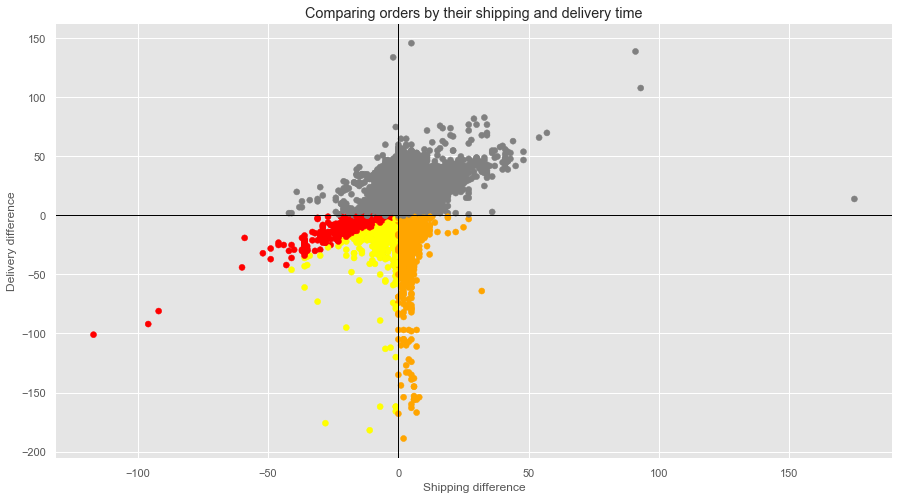

In [146]:
plot_late_order(delivered_orders)

1. **Grey points**: order was delivered on time
2. **Orange points**: order was late because of the logistic firm
3. **Yellow points**: order was late because of the seller
4. **Red points**: order was late because of both the seller and the logistic firm

In [175]:
X = [x for x in delivered_orders.shipping_difference]
Y = [y for y in delivered_orders.delivery_difference]

grey_points = [i for i, x in enumerate(X) if (X[i]>=0) and (Y[i]>=0)]
orange_points = [i for i, x in enumerate(X) if (X[i]>=0) and (Y[i]<0)]
yellow_points = [i for i, x in enumerate(X) if ((X[i]==Y[i]) and (Y[i]<0)) or ((X[i]>Y[i]) and (X[i]<0))]
red_points = [i for i, x in enumerate(X) if (Y[i]<0) and (X[i]>Y[i])]

In [176]:
print(" %5.2f pct. of the orders was delivered on time" %((len(grey_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the logistic firm" %((len(orange_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of the seller" %((len(yellow_points)/len(X))*100))
print(" %5.2f pct. of the orders was delivered late because of both the seller and logistic firm" %((len(red_points)/len(X))*100))

 85.18 pct. of the orders was delivered on time
  5.80 pct. of the orders was delivered late because of the logistic firm
  1.33 pct. of the orders was delivered late because of the seller
  6.88 pct. of the orders was delivered late because of both the seller and logistic firm


# <font color='blue'>Part 2</font>: Prediction - Estimated delivery time

In [90]:
def count_missing_values(df):
    missing = df.isna()
    num_missing = pd.DataFrame(missing.sum(),columns=['Number'])
    num_missing['Percentage'] = round(num_missing / len(df),4)
    
    print(num_missing)

In [91]:
count_missing_values(delivered_orders)

                               Number  Percentage
order_id                            0      0.0000
customer_id                         0      0.0000
seller_id                           0      0.0000
product_id                          0      0.0000
order_purchase_timestamp            0      0.0000
order_approved_at                  15      0.0001
order_delivered_carrier_date        2      0.0000
order_delivered_customer_date       8      0.0001
order_estimated_delivery_date       0      0.0000
order_item_id                       0      0.0000
shipping_limit_date                 0      0.0000
price                               0      0.0000
freight_value                       0      0.0000
customer_lat                      288      0.0026
customer_lon                      288      0.0026
seller_lat                        249      0.0023
seller_lon                        249      0.0023


# <font color='blue'>Part 3</font>: Prediction - Late delivery (yes or no)

# <font color='blue'>Part 4</font>: Clustering - Warehouse locations